In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    EBLAbsorptionNormSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, FixedPointingInfo, PointingMode, observatory_locations
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets

from gammapy.estimators import FluxPointsEstimator
from scipy.stats import chi2
from gammapy.stats.utils import ts_to_sigma
from IPython.core.display import HTML 

In [3]:
from gammapy.catalog import SourceCatalog4FGL
from regions import CircleSkyRegion


In [4]:
catalog = SourceCatalog4FGL()
catalog.description
#catalog.table


'LAT 8-year point source catalog'

In [5]:
source = catalog["PKS 2155-304"]
print(source)


*** Basic info ***

Catalog row index (zero-based) : 6206
Source name          : 4FGL J2158.8-3013
Extended name        :                   
Associations     : PKS 2155-304, PKS 2155-304, 3FGL J2158.8-3013, 3FHL J2158.8-3013, 2AGL J2157-3015, 3EG J2158-3023, EGR J2200-3015
ASSOC_PROB_BAY   : 1.000
ASSOC_PROB_LR    : 1.000
Class1           : bll  
Class2           :           
TeVCat flag      : P

*** Other info ***

Significance (100 MeV - 1 TeV)   : 238.600
Npred                            : 17766.5

Other flags          : 0

*** Position info ***

RA                   : 329.714 deg
DEC                  : -30.225 deg
GLON                 : 17.731 deg
GLAT                 : -52.243 deg

Semimajor (68%)      : 0.0049 deg
Semiminor (68%)      : 0.0049 deg
Position angle (68%) : -22.82 deg
Semimajor (95%)      : 0.0079 deg
Semiminor (95%)      : 0.0079 deg
Position angle (95%) : -22.82 deg
ROI number           : 932

*** Spectral info ***

Spectrum type                                 :

In [6]:
catalog.table[source.row_index]

Source_Name,DataRelease,RAJ2000,DEJ2000,GLON,GLAT,Conf_68_SemiMajor,Conf_68_SemiMinor,Conf_68_PosAng,Conf_95_SemiMajor,Conf_95_SemiMinor,Conf_95_PosAng,ROI_num,Extended_Source_Name,Signif_Avg,Pivot_Energy,Flux1000,Unc_Flux1000,Energy_Flux100,Unc_Energy_Flux100,SpectrumType,PL_Flux_Density,Unc_PL_Flux_Density,PL_Index,Unc_PL_Index,LP_Flux_Density,Unc_LP_Flux_Density,LP_Index,Unc_LP_Index,LP_beta,Unc_LP_beta,LP_SigCurv,LP_EPeak,Unc_LP_EPeak,PLEC_Flux_Density,Unc_PLEC_Flux_Density,PLEC_IndexS,Unc_PLEC_IndexS,PLEC_ExpfactorS,Unc_PLEC_ExpfactorS,PLEC_Exp_Index,Unc_PLEC_Exp_Index,PLEC_SigCurv,PLEC_EPeak,Unc_PLEC_EPeak,Npred,Flux_Band,Unc_Flux_Band,nuFnu_Band,Sqrt_TS_Band,Variability_Index,Frac_Variability,Unc_Frac_Variability,Signif_Peak,Flux_Peak,Unc_Flux_Peak,Time_Peak,Peak_Interval,Flux_History,Unc_Flux_History,Sqrt_TS_History,ASSOC_4FGL,ASSOC_FGL,ASSOC_FHL,ASSOC_GAM1,ASSOC_GAM2,ASSOC_GAM3,TEVCAT_FLAG,ASSOC_TEV,CLASS1,CLASS2,ASSOC1,ASSOC2,ASSOC_PROB_BAY,ASSOC_PROB_LR,RA_Counterpart,DEC_Counterpart,Unc_Counterpart,Flags
,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,,MeV,1 / (s cm2),1 / (s cm2),erg / (s cm2),erg / (s cm2),,1 / (MeV s cm2),1 / (MeV s cm2),,,1 / (MeV s cm2),1 / (MeV s cm2),,,,,,MeV,MeV,1 / (MeV s cm2),1 / (MeV s cm2),,,,,,,,MeV,MeV,,1 / (s cm2),1 / (s cm2),erg / (s cm2),,,,,,1 / (s cm2),1 / (s cm2),s,s,1 / (s cm2),1 / (s cm2),,,,,,,,,,,,,,,,deg,deg,deg,
bytes18,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bytes18,float32,float32,float32,float32,float32,float32,bytes17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[8],"float32[8,2]",float32[8],float32[8],float32,float32,float32,float32,float32,float32,float64,float32,float32[12],"float32[12,2]",float32[12],bytes18,bytes18,bytes18,bytes18,bytes18,bytes18,bytes1,bytes30,bytes5,bytes10,bytes28,bytes28,float32,float32,float64,float64,float32,int16
4FGL J2158.8-3013,1,329.7141,-30.2251,17.7308,-52.2434,0.0049,0.0049,-22.820,0.0079,0.0079,-22.820,932,,238.600,1146.89,2.0042e-08,2.1901e-10,2.1198e-10,3.0064e-12,LogParabola,1.2817e-11,1.2711e-13,1.8496,0.0067,1.3413e-11,1.4609e-13,1.7672,0.0088,0.0406,0.0038,7.781,20188.0,4064.4,1.3032e-11,1.3417e-13,1.7755,0.0095,0.02278,0.00228,0.6667,--,8.477,23880.7,2501.1,17766.49,9.7760186e-08 .. 1.3523291e-10,-3.2013567e-08 .. 1.75857e-11,1.5950439e-11 .. 2.203654e-11,2.961729 .. 29.674353,745.3666,0.2522,0.0546,99.613,1.7118121e-07,3.9726333e-09,255223712.0,31332582.0,1.7118121e-07 .. 8.565562e-08,-3.9726333e-09 .. 3.2098462e-09,99.61309 .. 59.28383,4FGL J2158.8-3013,3FGL J2158.8-3013,3FHL J2158.8-3013,2AGL J2157-3015,3EG J2158-3023,EGR J2200-3015,P,PKS 2155-304,bll,,PKS 2155-304,,1.0000,0.9997,329.7169,-30.2256,0.00000,0


In [7]:
target_position = source.position

sky_model = source.sky_model()

print(sky_model)

SkyModel

  Name                      : 4FGL J2158.8-3013
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         




<Axes: xlabel='Energy [$\\mathrm{MeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

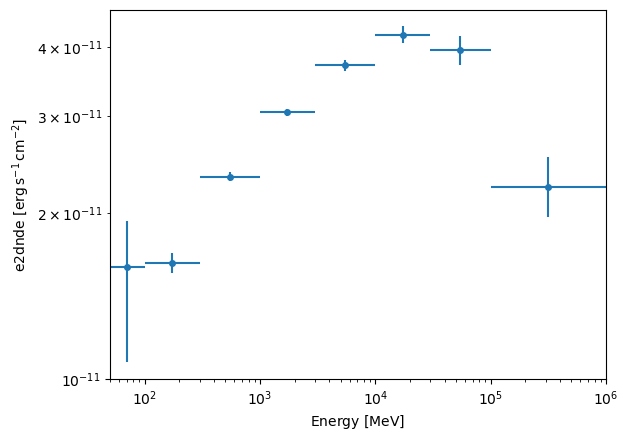

In [8]:
source.flux_points.plot(sed_type="e2dnde")

## Simulation

We will simulate using the CTA-1DC IRFs shipped with gammapy. Note that for dedictaed CTA simulations, you can simply use [`Observation.from_caldb()`]() without having to externally load the IRFs

In [9]:
# Loading IRFs
from feupy.cta.irfs import Irfs
from feupy.utils.geometry import *
irfs_config = Irfs.IRFS_OPTIONS
irfs_config

# Loading IRFs
irfs_config_ =['South', 'AverageAz', '40deg', '50h']
irfs = Irfs.get_irfs(irfs_config_)
obs_location = Irfs.get_obs_loc(irfs_config)
irfs_label = Irfs.get_irfs_label(irfs_config_)

In [10]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 10.0 * u.hr

pointing_angle = 0*u.deg

offset = 0.3*u.deg 

pointing_position = create_pointing_position(target_position, pointing_angle, offset)
pointing = create_pointing(pointing_position)
print(f"{pointing}\n")

FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (329.71411133, -29.92509956)>



In [11]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 2.0, 15), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(6, 6),
    frame="icrs",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [12]:
#explain global Models object
# models = Models()

In [13]:
int_model = sky_model.spectral_model
print(int_model)

LogParabolaSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral amplitude 1.3413e-11 MeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.1469e+03            MeV ... nan   True   False     
spectral     alpha 1.7672e+00                ... nan  False   False     
spectral      beta 4.0590e-02                ... nan  False   False     


In [14]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.

redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

spectral_model = ebl * int_model
spatial_model = sky_model.spatial_model
model_simu = SkyModel(spectral_model=spectral_model, 
                      spatial_model=spatial_model,
                      name="model-simu")

In [15]:
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectra

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [16]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.42
	duration          : 36000.00 s
	pointing (icrs)   : 329.7 deg, -29.9 deg

	deadtime fraction : 0.0%



In [17]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [18]:
%%time

# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 1319181 
  Total background counts         : 1305982.37
  Total excess counts             : 13198.63

  Predicted counts                : 1319404.05
  Predicted background counts     : 1305982.37
  Predicted excess counts         : 13421.67

  Exposure min                    : 2.52e+05 m2 s
  Exposure max                    : 1.39e+11 m2 s

  Number of total bins            : 1260000 
  Number of fit bins              : 1244348 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -1265142.78

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : model-simu
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    P

In [19]:
dataset.counts.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 14)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 329.7 deg, -30.2 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 329.7 deg, -30.2 deg

Now use this dataset as you would in all standard analysis. You can plot the maps, or proceed with your custom analysis. 
In the next section, we show the standard 3D fitting as in [analysis_3d](analysis_3d.ipynb).

In [20]:
# To plot, eg, counts:
dataset.excess.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

<WCSAxes: >

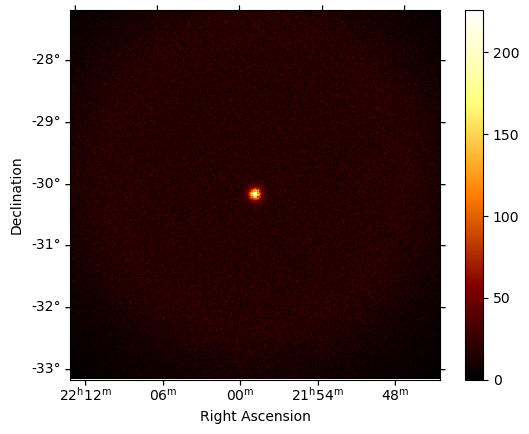

In [21]:
dataset.counts.sum_over_axes().plot(add_cbar=True)

In [22]:
dataset.counts.get_image_by_coord({"energy": "5 TeV"})

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat']
	shape : (300, 300)
	ndim  : 2
	unit  : 
	dtype : int64

In [60]:
dataset.write("pks2155-simulated.fits.gz", overwrite=True)

In [61]:
#read the dataset
cta_dataset = MapDataset.read("pks2155-simulated.fits.gz", name="cta_dataset")

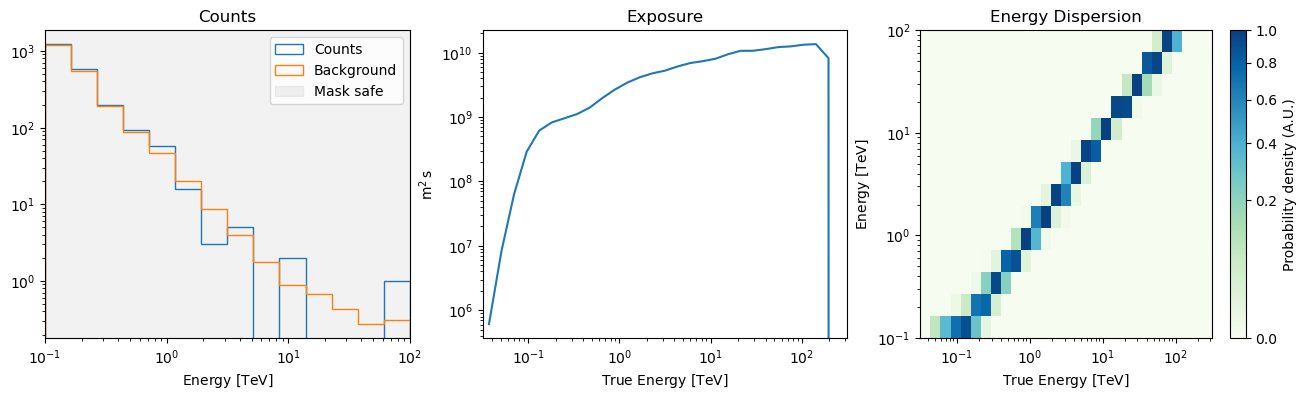

In [62]:
# src_pos = SkyCoord.from_name("PKS 2155-304")

center=target_position
region = CircleSkyRegion(center=center, radius=0.4*u.deg)
spectrum_dataset = cta_dataset.to_spectrum_dataset(on_region=region)
spectrum_dataset.peek()

## Exercise 1: fit the simulated dataset

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

In [26]:
models_fit = models.copy()

In [27]:
# We want to fit the background in this case, so we will let the norm free but the spectral index frozen
models_fit["dataset-simu-bkg"].spectral_model.norm.frozen = False
models_fit["dataset-simu-bkg"].spectral_model.tilt.frozen = True

In [28]:
cta_dataset.models = models_fit
print(cta_dataset.models)

DatasetModels

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         




In [29]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result1 = fit.run(datasets=[cta_dataset])
stat_H1=result1.total_stat

W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00865388 is smaller than machine limit 0.0754087 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00865388 is above tolerance 0.002
CPU times: user 18.3 s, sys: 129 ms, total: 18.5 s
Wall time: 18.5 s


In [30]:
HTML(result1.minuit._repr_html_())

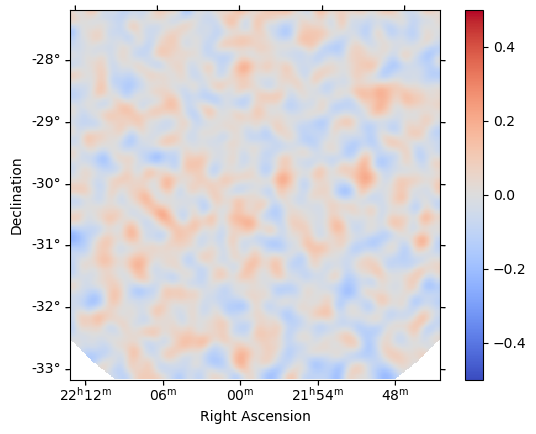

In [31]:
cta_dataset.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5);

In [32]:
fpe = FluxPointsEstimator(energy_edges=energy_reco.edges)
flux_points = fpe.run(datasets=[cta_dataset])

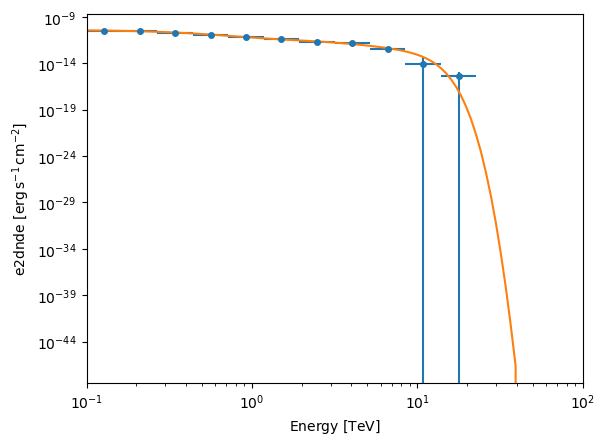

In [33]:
flux_points.plot(sed_type='e2dnde');
models_fit[0].spectral_model.plot([0.1,100]*u.TeV, sed_type='e2dnde');
models_fit[0].spectral_model.plot_error([0.1,100]*u.TeV, sed_type='e2dnde');

Compare the injected and fitted models: 

In [34]:
print(
    "True model: \n",
    model_simu,
    "\n\n Fitted model: \n",
    models_fit["model-simu"],
)

True model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   
    amplitude                     :   1.34e-11   +/- 1.5e-13 1 / (MeV s cm2)
    reference             (frozen):   1146.894       MeV         
    alpha                         :      1.767   +/-    0.01             
    beta                          :      0.041   +/-    0.00             
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

 

 Fitted model: 
 SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type    

**Estimating the $-2\ln\mathcal(L)$ of null hypothesis**
Fitting the data with just a background model. No source.

In [35]:
dataset.models = bkg_model
result0 = fit.run(datasets=[dataset])
stat_H0=result0.total_stat
print(stat_H0)

-1234319.8472695576


**Test Statistics of the point source**

In [36]:
delta_ts=-(stat_H1-stat_H0) # standard formula is TS=-2(LogLike1-LogLike0) but default stat in gammapy is -2 log(L)
df = len(result1.models.parameters.free_parameters.names)-len(result0.models.parameters.free_parameters.names)
sigma = ts_to_sigma(delta_ts, df=df)
print(f"The delta_ts  of H1 vs H0: {delta_ts:.3f}, that gives a p-value of {chi2.sf(delta_ts, df)}")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

The delta_ts  of H1 vs H0: 30828.187, that gives a p-value of 0.0
Converting this to a significance gives: inf σ


## Exercise 2: using simulations, determine the minimal time to detect significantly an exponential cut-off in the spectrum of a weak source

In this section, we do a usual 3D fit with the same model used to simulated the data and see the stability of the simulations. Often, it is useful to simulate many such datasets and look at the distribution of the reconstructed parameters.

In [37]:
# model_copy = pks_model.copy()
# spec = LogParabolaSpectralModel()
# #spec = ExpCutoffPowerLawSpectralModel()
# redshift = 0.116
# ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
# model_fp = SkyModel(spec*ebl, name="model_fp")
# spec.parameters["reference"].quantity = 1*u.TeV
# spectral_model = ExpCutoffPowerLawSpectralModel()
# spatial_model = PointSpatialModel()
# pks_model = SkyModel(spectral_model=spectral_model,
#                      spatial_model=spatial_model, 
#                     name="pks_model")

In [38]:
# Define the pointing
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 10.0 * u.hr

pointing_angle = 0*u.deg

offset = 0.5*u.deg 

pointing_position = create_pointing_position(target_position, pointing_angle, offset)
pointing = create_pointing(pointing_position)
print(f"{pointing}\n")

# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 2.0, 15), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(6, 6),
    frame="icrs",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)


# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = source.sky_model().spatial_model
# spectral_model = source.sky_model().spectral_model
spectral_model = ExpCutoffPowerLawSpectralModel(index=2.2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", 
                                                lambda_=1/40. * u.Unit("TeV-1"))

model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model*ebl,
    name="model-simu",
)
bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])

# Creation of the generic makers
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (329.71411133, -29.72509956)>



In [39]:
livetime_scan = [1, 5, 10.0, 20.] * u.hr

In [40]:
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.200   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.025   +/-    0.00 1 / TeV     
    alpha                 (frozen):      1.000                   
    alpha_norm            (frozen):      1.000                   
    redshift              (frozen):      0.116                   
    lon_0                         :    329.714   +/-    0.00 deg         
    lat_0                         :    -30.225   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : 

In [41]:
%%time

results = []
for idx, livetime in enumerate(livetime_scan[0:1]):
    # Do the simulation
    print(f"Simulation for Livetime = {livetime}")
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs, obs_id=idx)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = models
    dataset.fake()

    # Do the 3D fit
    models_fit = models.copy()
    spatial_model = models_fit["model-simu"].spatial_model
    spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
    spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5
    spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
    spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5
    dataset.models = models_fit
    fit = Fit(optimize_opts={"print_level": 1})
    result1 = fit.run(datasets=[dataset])
    stat_H1=result1.total_stat

    # Do the 3D fit with only the Bkg model
    dataset.models = bkg_model
    result0 = fit.run(datasets=[dataset])
    stat_H0=result0.total_stat

    delta_ts=-(stat_H1-stat_H0)
    df = len(result1.models.parameters.free_parameters.names)-len(result0.models.parameters.free_parameters.names)
    sigma = ts_to_sigma(delta_ts, df=df)

    sp_model = result1.models["model-simu"].spectral_model
    Ec = 1./sp_model.model1.lambda_.quantity
    err = Ec**2 * sp_model.model1.lambda_.error / u.TeV
    result = {
        "livetime": livetime,
        "success": result1.success,
        "ecut": Ec,
        "ecut_err": err,
        "sigma": sigma
    }
    results.append(result)

Simulation for Livetime = 1.0 h
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.117734 Requested 0.0002
W MnPosDef Matrix forced pos-def by adding to diagonal 0.070424
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 0.029025 Requested 0.0002
W VariableMetricBuilder FunctionMinimum is invalid after second try
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No convergence; Edm 0.00546269 is above tolerance 0.002
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
W VariableMetricBuilder No convergence; Edm 0.00546269

In [42]:
# print(results)

<Figure size 1000x1000 with 0 Axes>

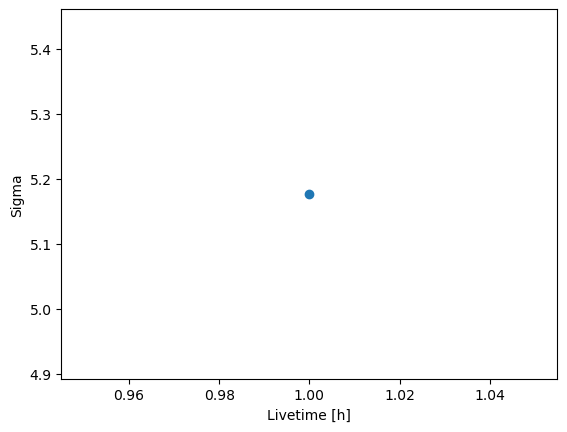

In [43]:
duration = [_['livetime'].to("h").value for _ in results]
sigma = [_['sigma'] for _ in results]

plt.figure(figsize=(10, 10));
fig, ax = plt.subplots();
ax.plot(duration, sigma, marker="o", ls="none");
ax.set_xlabel("Livetime [h]");
ax.set_ylabel("Sigma");

## Going further
- The simulations could be improved by making 100 simulations per observation time and returning the average cutoff energy and its dispersion (RMS)
- When the fit does not converge, one can compute a lower limit on the cutoff energy, ie an upper limit on lambda. In that purpose, one should compute the likelihood profile for fixed values of lambda while leaving free the other parameters
- Simulate a source exhibing a log-normal variable of its flux as a function of time (the tutorial about [the energy-dependent temporal evolution](https://docs.gammapy.org/1.1/tutorials/analysis-3d/event_sampling_nrg_depend_models.html) can be used as exemple) - PS: with the v1.2 of Gammapy, the interface has been simplified

In [44]:
model_copy = model_simu.copy()
# model_copy = pks_model.copy()
spec = LogParabolaSpectralModel()
#spec = ExpCutoffPowerLawSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
model_fp = SkyModel(spec*ebl, name="model_fp")
spec.parameters["reference"].quantity = 1*u.TeV

# edshift = 0.116
# ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
# model_fp = SkyModel(spec*ebl, name="model_fp")
# # spec.parameters["reference"].quantity = 3*u.TeV

In [45]:
fermi_catalag = SourceCatalog4FGL()
source = fermi_catalag["PKS 2155-304"]
fermi_flux_points = source.flux_points

In [46]:
fermi_fp_dataset = FluxPointsDataset(data=fermi_flux_points, 
                                     models=model_fp, 
                                     name="fermi")
cta_fp_dataset = FluxPointsDataset(data=flux_points, 
                                   models=model_fp, 
                                   name="cta")
datasets = Datasets([fermi_fp_dataset, cta_fp_dataset])

In [47]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : FluxPointsDataset
  Name       : fermi
  Instrument : 
  Models     : ['model_fp']

Dataset 1: 

  Type       : FluxPointsDataset
  Name       : cta
  Instrument : 
  Models     : ['model_fp']




In [48]:
%%time
fit4 = Fit(backend='sherpa')
result4 = fit4.run(datasets=datasets)
result4.success

No covariance estimate - not supported by this backend.


CPU times: user 31.1 s, sys: 8.03 ms, total: 31.1 s
Wall time: 31.1 s


True

In [49]:
model_fp.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,int64,float64,float64,bool,bool,str1
spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,beta,1.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


(<Axes: xlabel='Energy [$\\mathrm{MeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{MeV}$]', ylabel='Residuals\n (data - model) / model'>)

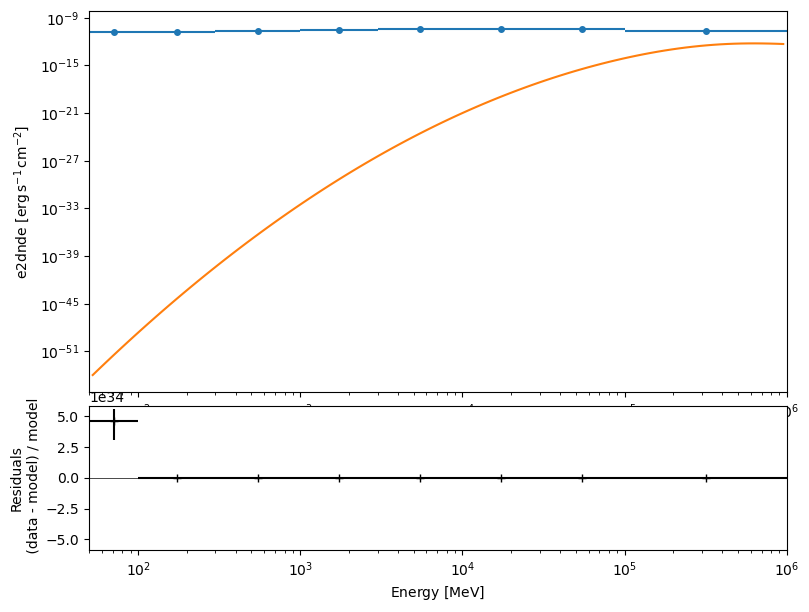

In [50]:
fermi_fp_dataset.plot_fit()

(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\n (data - model) / model'>)

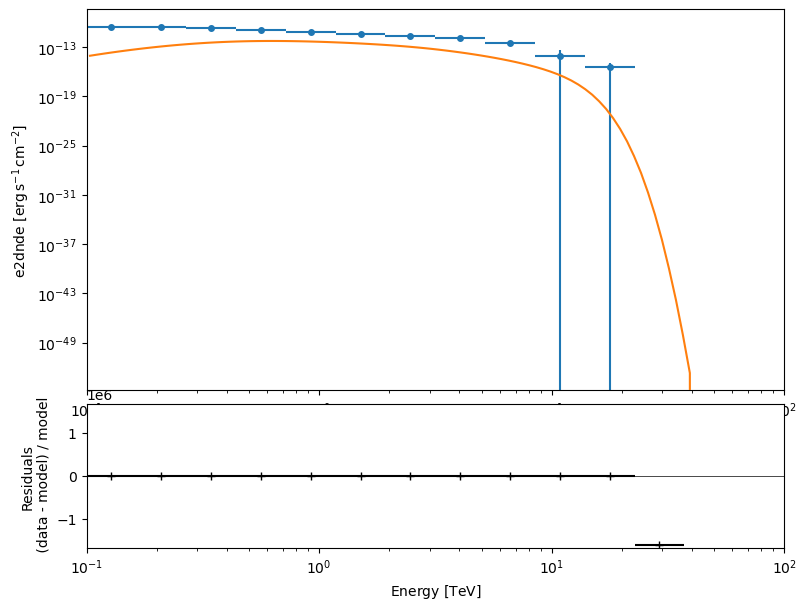

In [51]:
cta_fp_dataset.plot_fit()

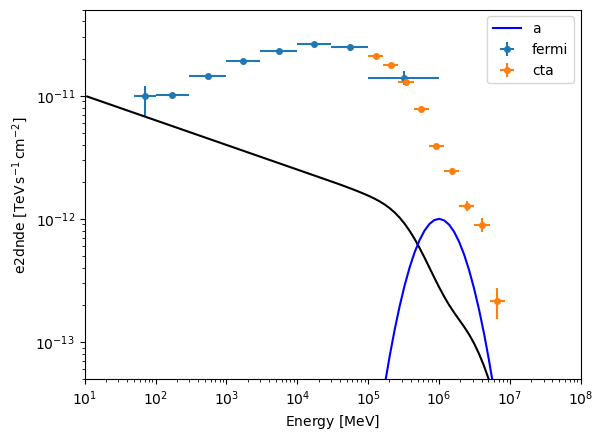

In [59]:
ax = plt.subplot()

kwargs = {"ax": ax, "sed_type": "e2dnde"}

ax.yaxis.set_units( u.Unit("TeV cm-2 s-1"))

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [1e-5, 1e2] * u.TeV
model_simu.spectral_model.plot(energy_bounds=energy_bounds, color="k", **kwargs)
datasets.models[0].spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
spec.plot(energy_bounds=energy_bounds, color="b", **kwargs, label='a')
ax.set_ylim(5e-14, 5e-11)
ax.set_xlim(energy_bounds)
ax.legend()

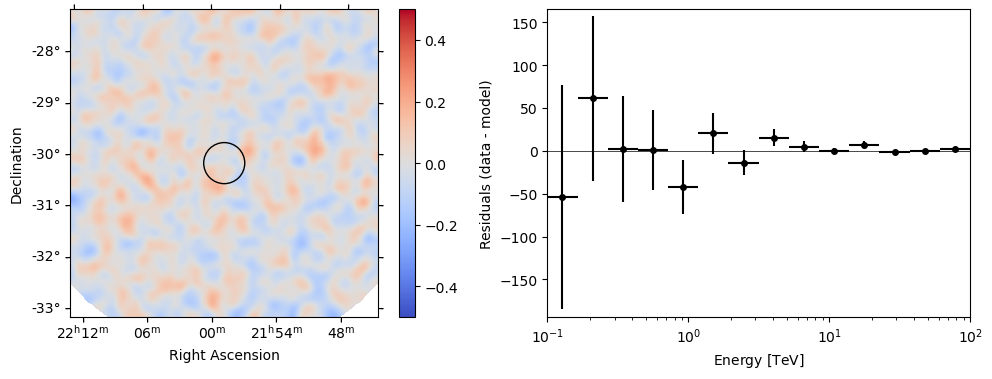

In [53]:
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);